<a href="https://colab.research.google.com/github/African-Quant/FOREX_RelativeStrengthOscillator/blob/main/Oanda_RelativeStrength_NChf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Installation
!pip install git+https://github.com/yhilpisch/tpqoa.git --upgrade --quiet
!pip install pykalman --quiet

!pip install --upgrade mplfinance --quiet

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 184kB 9.1MB/s 
     |████████████████████████████████| 235kB 7.0MB/s 
     |████████████████████████████████| 71kB 3.9MB/s 


In [2]:
#@title Imports 

import tpqoa

import numpy as np
import pandas as pd

from pykalman import KalmanFilter

%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

from datetime import date, timedelta

import warnings
warnings.filterwarnings("ignore")

In [3]:
#@title Oanda API
path = '/content/drive/MyDrive/Oanda_Algo/pyalgo.cfg'
api = tpqoa.tpqoa(path)

In [4]:
#@title Symbols/Currency Pairs
def symbolsList():
  symbols = []
  syms = api.get_instruments()
  for x in syms:
    symbols.append(x[1])

  return symbols

symbols = symbolsList()

pairs = ['AUD_CAD',  'AUD_CHF', 'AUD_JPY', 'AUD_NZD', 'AUD_USD', 'CAD_CHF',
         'CAD_JPY', 'CHF_JPY', 'EUR_AUD', 'EUR_CAD', 'EUR_CHF', 'EUR_GBP',
         'EUR_JPY', 'EUR_NZD', 'EUR_USD', 'GBP_AUD', 'GBP_CAD', 'GBP_CHF', 
         'GBP_JPY', 'GBP_NZD',  'GBP_USD', 'NZD_CAD', 'NZD_CHF', 'NZD_JPY', 
         'NZD_USD', 'USD_CAD',  'USD_CHF', 'USD_JPY',]

In [5]:
#@title getData(instr, gran = 'D', td=1000)
def getData(instr, gran = 'D', td=1000):
  start = f"{date.today() - timedelta(td)}"      
  end = f"{date.today() - timedelta(1)}"        
  granularity = gran          
  price = 'M' # price: string one of 'A' (ask), 'B' (bid) or 'M' (middle)
  data = api.get_history(instr, start, end, granularity, price)
  data.drop(['complete'], axis=1, inplace=True)
  data.reset_index(inplace=True)
  data.rename(columns = {'time':'Date','o':'Open','c': 'Close', 'h':'High', 'l': 'Low'}, inplace = True)
  data.set_index('Date', inplace=True)
  return data

In [6]:
#@title Indexes
def USD_Index():
  '''Creating a USD Index from a basket of instruments
     denominated in dollars    
  '''
  USD = ['EUR_USD', 'GBP_USD', 'USD_CAD', 'USD_CHF', 
         'USD_JPY',  'AUD_USD', 'NZD_USD']  


  
  df = pd.DataFrame()
  for i in USD:
    data = getData(i).ffill(axis='rows')
    
    # setting the Dollar as the base
    if '_USD' == i[-4:]:
      data[f'{i}'] = (data['Close'])**(-1)
     
    else:
      data[f'{i}'] = data['Close']
            
    df = pd.concat([df, data.loc[:,f'{i}']], axis=1)

    
  

  df['US_index']  = 1  
  for i in range(len(USD)):
        df['US_index'] *= df[USD[i]]
    

  return ((df['US_index'])**(1/(len(USD)))).to_frame()


def EURO_Index():
  '''Creating a EUR Index from a basket of instruments
     denominated in EUROs    
  '''
  EUR = ['EUR_USD', 'EUR_GBP', 'EUR_JPY', 'EUR_CHF', 'EUR_CAD',
         'EUR_AUD', 'EUR_NZD']  


  
  df = pd.DataFrame()
  for i in EUR:
    data = getData(i).ffill(axis='rows')
    
    data[f'{i}'] = data['Close']
            
    df = pd.concat([df, data.loc[:,f'{i}']], axis=1)

    
  

  df['EUR_index'] = 1  
  for i in range(len(EUR)):
        df['EUR_index'] *= df[EUR[i]]
    

  return ((df['EUR_index'])**(1/(len(EUR)))).to_frame()


def GBP_Index():
  '''Creating a GBP Index from a basket of instruments
     denominated in Pound Sterling    
  '''
  GBP = ['GBP_USD', 'EUR_GBP', 'GBP_JPY', 'GBP_CHF', 'GBP_CAD', 
         'GBP_AUD', 'GBP_NZD']  

  df = pd.DataFrame()
  for i in GBP:
    data = getData(i).ffill(axis='rows')
    
    # setting the Dollar as the base
    if '_GBP' == i[-4:]:
      data[f'{i}'] = (data['Close'])**(-1)
     
    else:
      data[f'{i}'] = data['Close']
            
    df = pd.concat([df, data.loc[:,f'{i}']], axis=1)

    
  

  df['GBP_index'] = 1  
  for i in range(len(GBP)):
        df['GBP_index'] *= df[GBP[i]]

  return ((df['GBP_index'])**(1/(len(GBP)))).to_frame()


def CHF_Index():
  '''Creating a CHF Index from a basket of instruments
     denominated in Swiss Francs    
  '''
  CHF = ['CHF_JPY', 'EUR_CHF', 'GBP_CHF', 'USD_CHF', 'CAD_CHF', 
         'AUD_CHF', 'NZD_CHF']  

  df = pd.DataFrame()
  for i in CHF:
    data = getData(i).ffill(axis='rows')
    
    # setting the Dollar as the base
    if '_CHF' == i[-4:]:
      data[f'{i}'] = (data['Close'])**(-1)
     
    else:
      data[f'{i}'] = data['Close']
            
    df = pd.concat([df, data.loc[:,f'{i}']], axis=1)

    
  

  df['CHF_index'] = 1  
  for i in range(len(CHF)):
        df['CHF_index'] *= df[CHF[i]]
    

  return ((df['CHF_index'])**(1/(len(CHF)))).to_frame()



def CAD_Index():
  '''Creating a CAD Index from a basket of instruments
     denominated in Canadian Dollars    
  '''
  CAD = ['CAD_JPY', 'EUR_CAD', 'GBP_CAD', 'USD_CAD', 'CAD_CHF', 
         'AUD_CAD', 'NZD_CAD']  

  df = pd.DataFrame()
  for i in CAD:
    data = getData(i).ffill(axis='rows')
    
    # setting the Dollar as the base
    if '_CAD' == i[-4:]:
      data[f'{i}'] = (data['Close'])**(-1)
     
    else:
      data[f'{i}'] = data['Close']
            
    df = pd.concat([df, data.loc[:,f'{i}']], axis=1)

    
  

  df['CAD_index'] = 1  
  for i in range(len(CAD)):
        df['CAD_index'] *= df[CAD[i]]

  return ((df['CAD_index'])**(1/(len(CAD)))).to_frame()



def JPY_Index():
  '''Creating a JPY Index from a basket of instruments
     denominated in Swiss Francs    
  '''
  JPY = ['CAD_JPY', 'EUR_JPY', 'GBP_JPY', 'USD_JPY', 'CHF_JPY', 
         'AUD_JPY', 'NZD_JPY']  

  df = pd.DataFrame()
  for i in JPY:
    data = getData(i).ffill(axis='rows')
    
    # setting the Japanese Yen as the base
    data[f'{i}'] = (data['Close'])**(-1)
     
    
            
    df = pd.concat([df, data.loc[:,f'{i}']], axis=1)

    
  

  df['JPY_index'] = 1
  for i in range(len(JPY)):
        df['JPY_index'] *= df[JPY[i]]

  return ((df['JPY_index'])**(1/(len(JPY)))).to_frame()  

  


def AUD_Index():
  '''Creating a AUD Index from a basket of instruments
     denominated in Australian Dollar   
  '''
  AUD = ['AUD_JPY', 'EUR_AUD', 'GBP_AUD', 'AUD_USD', 'AUD_CAD', 
         'AUD_CHF', 'AUD_NZD']  

  df = pd.DataFrame()
  for i in AUD:
    data = getData(i).ffill(axis='rows')
    
    # setting the Aussie Dollar as the base
    if '_AUD' == i[-4:]:
      data[f'{i}'] = (data['Close'])**(-1)
     
    else:
      data[f'{i}'] = data['Close']
            
    df = pd.concat([df, data.loc[:,f'{i}']], axis=1)

    
  

  df['AUD_index'] = 1  
  for i in range(len(AUD)):
        df['AUD_index'] *= df[AUD[i]]
    

  return ((df['AUD_index'])**(1/(len(AUD)))).to_frame()



def NZD_Index():
  '''Creating a NZD Index from a basket of instruments
     denominated in New Zealand Dollar    
  '''
  NZD = ['NZD_JPY', 'EUR_NZD', 'GBP_NZD', 'NZD_USD', 'NZD_CAD', 
         'NZD_CHF', 'AUD_NZD']  

  df = pd.DataFrame()
  for i in NZD:
    data = getData(i).ffill(axis='rows')
    
    # setting the Dollar as the base
    if '_NZD' == i[-4:]:
      data[f'{i}'] = (data['Close'])**(-1)
     
    else:
      data[f'{i}'] = data['Close']
            
    df = pd.concat([df, data.loc[:,f'{i}']], axis=1)

    
  

  df['NZD_index'] = 1  
  for i in range(len(NZD)):
        df['NZD_index'] *= df[ NZD[i]]
    

  return ((df['NZD_index'])**(1/(len(NZD)))).to_frame()

def eSuperRCS(df):
  """
  This code computes the super smoother introduced by John Ehlers
  """
  spr = df.to_frame().copy()

  # HighPass filter cyclic components whose periods are shorter than 48 bars
  alpha1 = (np.cos(0.707*2*np.pi/48) + np.sin(0.707*2*np.pi/48) - 1)/np.cos(0.707*2*np.pi/48)
  hiPass = pd.DataFrame(None, index=spr.index, columns=['filtered'])

  for i in range(len(spr)):
    if i < 3:
      hiPass.iloc[i, 0] = spr.iat[i, 0]
    else:
      
      hiPass.iloc[i, 0] = ((1 - alpha1/2)*(1 - alpha1/2)*(spr.iat[i, 0] 
              - 2*spr.iat[i-1, 0] + spr.iat[i-2, 0] + 2*(1 - alpha1)*hiPass.iat[i-1, 0]
              - (1 - alpha1)**2 *hiPass.iat[i-2, 0]))
      

  # SuperSmoother
  a1 = np.exp(-1.414*(np.pi) / 10)
  b1 = 2*a1*np.cos(1.414*(np.pi) / 10)
  c2 = b1
  c3 = -a1*a1
  c1 = 1 - c2 - c3
  Filt = pd.DataFrame(None, index=spr.index, columns=['filtered'])
  for i in range(len(spr)):
    if i < 3:
      Filt.iloc[i, 0] = hiPass.iat[i, 0]

    else:
      Filt.iloc[i, 0] = c1*(hiPass.iat[i, 0] + hiPass.iat[i - 1, 0]/ 2 + c2*Filt.iat[i-1, 0] + c3*Filt.iat[i-2, 0])

  Filt['eSuperRCS'] = RSI(Filt['filtered'])

  return Filt['eSuperRCS']

def RSI(series, period=25):
  delta = series.diff()
  up = delta.clip(lower=0) 
  dn = -1*delta.clip(upper=0)

  ema_up = up.ewm(com=period-1, adjust=False).mean()
  ewm_dn = dn.ewm(com=period-1, adjust=False).mean() 

  rs = (ema_up/ewm_dn)
  return 100 - 100 / (1 + rs)

def will_pr(data, lb=14):
    df = data[['High',	'Low', 'Close']].copy()
    df['max_hi'] = data['High'].rolling(window=lb).max()
    df['min_lo'] = data['Low'].rolling(window=lb).min()
    df['will_pr'] = 0
        
    for i in range(len(df)):
        try:
          df.iloc[i, 5] = ((df.iat[i, 3] - df.iat[i, 2])/(df.iat[i, 3] - df.iat[i, 4])) * (-100)
        
        except ValueError:
            pass
    
   
    return df['will_pr']


In [7]:
nchf = getData('NZD_CHF')
chf = CHF_Index()

nzd = NZD_Index()

df = pd.concat((nchf, chf, nzd), axis=1).ffill(axis='rows')

In [8]:
df

,Open,High,Low,Close,volume,CHF_index,NZD_index
2018-10-03 21:00:00,0.64630,0.64663,0.64199,0.64262,34881.0,2.170569,1.309186
2018-10-04 21:00:00,0.64252,0.64390,0.63800,0.63855,35011.0,2.170424,1.300498
2018-10-07 21:00:00,0.63924,0.64108,0.63716,0.64032,25411.0,2.168023,1.302823
2018-10-08 21:00:00,0.64022,0.64265,0.63912,0.64197,33336.0,2.164939,1.304652
2018-10-09 21:00:00,0.64240,0.64375,0.63776,0.63880,34721.0,2.170812,1.300318
...,...,...,...,...,...,...,...
2021-06-22 21:00:00,0.64459,0.64794,0.64349,0.64724,20367.0,2.235449,1.359676
2021-06-23 21:00:00,0.64808,0.64942,0.64564,0.64810,18599.0,2.236192,1.362281
2021-06-24 21:00:00,0.64796,0.64986,0.64758,0.64802,17203.0,2.237597,1.363166
2021-06-27 21:00:00,0.64913,0.65028,0.64704,0.64749,20126.0,2.234426,1.359630


In [9]:
tickers = ['NZD_index', 'CHF_index']

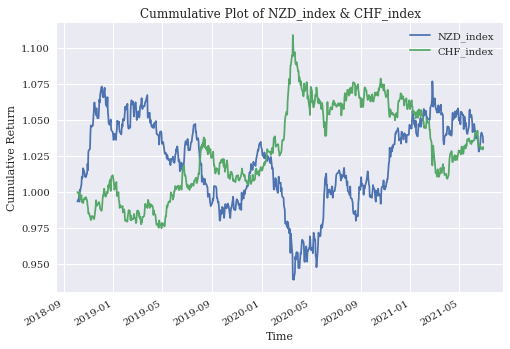

In [10]:
cumm_rtn = (1 + df[tickers].pct_change()).cumprod()
cumm_rtn.plot();
plt.ylabel('Cumulative Return');
plt.xlabel('Time');
plt.title('Cummulative Plot of NZD_index & CHF_index');

In [11]:
import statsmodels.api as sm
obs_mat = sm.add_constant(df[tickers[0]].values, prepend=False)[:, np.newaxis]

# y is 1-dimensional, (alpha, beta) is 2-dimensional
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))

In [12]:
state_means, state_covs = kf.filter(df[tickers[1]])

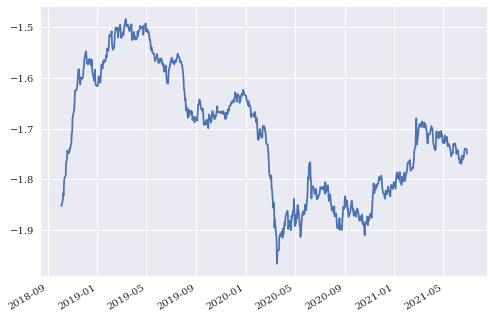

In [13]:
beta_kf = pd.DataFrame({'Slope': state_means[:, 0], 'Intercept': state_means[:, 1]},
                       index=df.index)

spread_kf = df[tickers[0]] - df[tickers[1]] * beta_kf['Slope'] - beta_kf['Intercept']
spread_kf = spread_kf
spread_kf.plot();

In [14]:
len(df)

731

In [15]:
df['spread'] = spread_kf
df['NZD/CHF'] = df['NZD_index']/df['CHF_index']
df['eSuperRCS'] = eSuperRCS(df['spread'])
df = df.iloc[-700:]

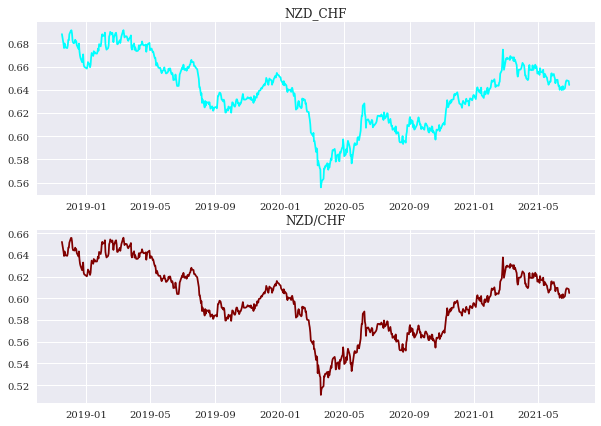

In [16]:
fig = plt.figure(figsize=(10, 7))
ax1, ax2 = fig.subplots(nrows=2, ncols=1)

ax1.plot(df.index, df['Close'],color='cyan' )
ax2.plot(df.index, df['NZD/CHF'].values, color='maroon')


ax1.set_title('NZD_CHF')
ax2.set_title('NZD/CHF')
plt.show()

In [17]:
def viewPlot(data, win = 150):
    
    fig = plt.figure(figsize=(17, 10))
    ax1, ax2 = fig.subplots(nrows=2, ncols=1)

    df1 = data.iloc[-win:, ]

    # High and Low prices are plotted
    for i in range(len(df1)):
      ax1.vlines(x = df1.index[i], ymin = df1.iat[i, 2], ymax = df1.iat[i, 1], color = 'magenta', linewidth = 2)
    

    ax2.plot(df1.index, df1['eSuperRCS'].values, color='maroon')

    ax2.axhline(55, color='green')
    ax2.axhline(45, color='green')
    ax2.axhline(50, color='orange')

    ax1.set_title('NZD_CHF')
    ax2.set_title('spread oscillator')
    return plt.show()

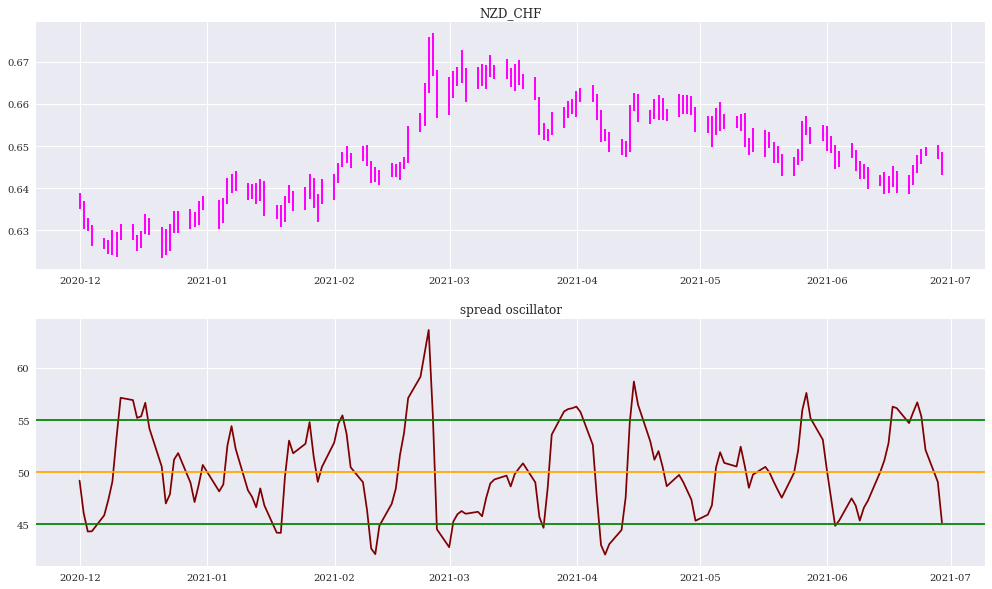

In [18]:
viewPlot(df, win = 150)